In [26]:
using DrWatson
@quickactivate "TriangularHubbard"

using DataStructures
using CodecXz
using SQLite
using DBInterface
using DataFrames
using Printf
using LsqFit
using ProgressMeter
using Quadmath
using Statistics
using ProgressMeter
using JSON
using MsgPack

using PyPlot
using PyCall
mpl = pyimport("matplotlib")
sns = pyimport("seaborn")

PyObject <module 'seaborn' from '/home/klee/.pyenv/versions/conda_jl/lib/python3.7/site-packages/seaborn/__init__.py'>

In [2]:
PyPlot.rc("axes", labelsize="medium", titlesize="medium")
PyPlot.rc("xtick", labelsize="small")
PyPlot.rc("ytick", labelsize="small")
PyPlot.rc("legend", fontsize="x-small")

#cmap = sns.color_palette("icefire", as_cmap=true)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=true)
# markers = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"];
markers = ["o", "v", "^", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]
;

In [3]:
n_sites = 9
shape_str = "(3,0)x(0,3)"
t = 1.0
U = 20.0

20.0

In [4]:
sectors_filepath = datadir("curie", shape_str, "sectors.sqlite3")
isfile(sectors_filepath)

true

In [54]:
conn = DBInterface.connect(SQLite.DB, sectors_filepath)
df = DataFrame(
    DBInterface.execute(conn, """
        SELECT dense_results.idx AS idx, nup, ndn, dim, temperature, partition, spin_correlation
        FROM dense_results
        INNER JOIN sectors
        ON dense_results.idx = sectors.idx
        WHERE hopping=? AND interaction=?
    """, (t, U))
)
for row in DBInterface.execute(conn, """SELECT * FROM sectors WHERE idx=925""")
    @show row
end

# for row in DBInterface.execute(conn, """
# SELECT sectors.idx, dim, temperature, partition, spin_correlation
# FROM dense_results
# INNER JOIN sectors
# ON dense_results.idx = sectors.idx
# WHERE hopping=1.0 AND interaction=20.0 AND partition BETWEEN 1E2 AND 1E8 AND nup > 2 AND ndn > 2"""
# )
#     @show row
#     break
# end
# df2 = DataFrame(
#     DBInterface.execute(conn, """
#         SELECT nup, ndn, temperature, partition
#         FROM sparse_results_collection
#         INNER JOIN sectors
#         ON sparse_results.idx = sectors.idx
#         WHERE hopping=? AND interaction=?
#     """, (t, U))
# )
DBInterface.close!(conn)

row = SQLite.Row:
 :idx  925
 :nup    3
 :ndn    3
 :tii    1
 :pii    1
 :pic    1
 :dim   80


In [24]:
filepath = datadir("curie", shape_str, "sparsedata", "sparse_U=20.0_idx=925_krylovdim=200_seed=0_t=1.0.mxz")

"/data/pn1_1/klee/Projects/TriangularHubbard/data/curie/(3,0)x(0,3)/sparsedata/sparse_U=20.0_idx=925_krylovdim=200_seed=0_t=1.0.mxz"

In [55]:
conv(x::AbstractArray) = conv.(x)
function conv(x::AbstractDict)
    if keys(x) == Set(["re", "im"])
        r = conv(x["re"])
        i = conv(x["im"])
        r = isnothing(r) ? NaN : r
        i = isnothing(i) ? NaN : i
        return complex(r, i)
    else
        return Dict(k => conv(v) for (k, v) in x)
    end
end
conv(x::Number) = x
conv(x::AbstractString) = x
conv(x::Nothing) = x

szsz = []
for (irow, row) in enumerate(eachrow(df))
    push!(szsz, conv(JSON.parse(row[:spin_correlation])))
end

In [56]:
df[!, :SzSz1] = [real(x[1]) for x in szsz]
df[!, :SzSz2] = [real(x[2]) for x in szsz]
df[!, :SzSz3] = [real(x[3]) for x in szsz]
;

In [57]:
df[:, :Sz] = 0.5*(df[:, :nup] - df[:, :ndn])
df[:, :charge] = df[:, :nup] + df[:, :ndn]
unique(sort(df[:, :Sz]))
# n_list = unique(df[:, :nup] .+ df[:, :ndn])
n_list = n_sites+5:-1:n_sites-6
temperatures = unique(sort(df[:, :temperature]))
;

In [69]:
data = open(filepath, "r") do io
    ioc = XzDecompressorStream(io)
    data = MsgPack.unpack(ioc)
    close(ioc)
    close(io)
    return data
end
simp(x::AbstractArray) = simp.(x)
simp(x::Number) = x
spin_correlation = simp(data["spin_correlation"])
m = let iT = 20
    [mean(spin_correlation[i][iT]) for i in 1:3]
end .* 80

3-element Vector{Float64}:
 146.74527398653925
 -22.814609993634406
  -4.928807012366482

In [67]:
temperatures[20]

1.4

In [68]:
conn = DBInterface.connect(SQLite.DB, sectors_filepath)
for row in DBInterface.execute(conn, """
        SELECT * FROM dense_results JOIN sectors ON dense_results.idx = sectors.idx WHERE dense_results.idx = 925
        AND temperature = 1.4
        """)
    @show row
end

row = SQLite.Row:
 :idx                 925
 :hopping               1.0
 :interaction          20.0
 :temperature           1.4
 :partition           912.8736986417288
 :energy            -6800.119221767656
 :energy_squared    52238.58799081744
 :spin_correlation       "[149.42736554918494,-23.25199702450227,-4.9576917010856265]"
 :idx                 925
 :nup                   3
 :ndn                   3
 :tii                   1
 :pii                   1
 :pic                   1
 :dim                  80


In [541]:
# . . . o * * o
#  . . * * x *
# . . * x * * .
#  . o * * o .
# . . . . . . .
#  . . . . . .

In [552]:
# fig = PyPlot.figure()
# ax = fig.gca()
# # ax.set_yscale("log")
# # ax.set_xscale("log")
# ax.plot(df[:, :Sz].^2 .* df[:, :partition], df[:, :Sz].^2 .* df[:, :partition] .- (df[:, :SzSz1] .+ df[:, :SzSz2].*6 .+ df[:, :SzSz3].*2).*9, "o")


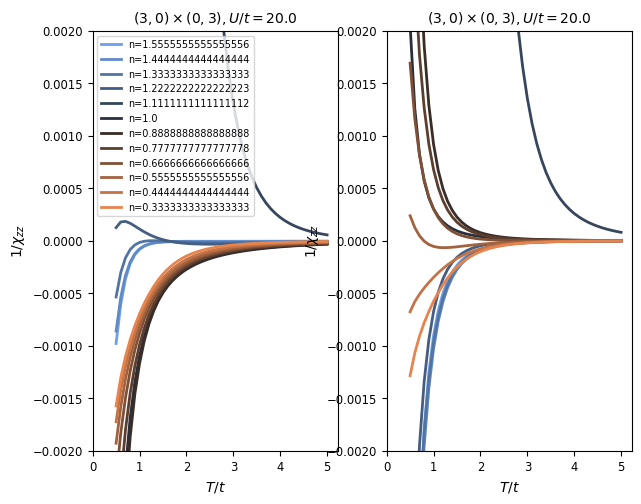

PyObject Text(0.5, 1.0, '$(3,0)\\times(0,3), U/t=20.0$')

In [568]:
fig = PyPlot.figure(figsize=(7, 5))
fig.subplots_adjust(left=0.18, right=0.95, top=0.94, bottom=0.1)

ax = fig.add_subplot(1,2,1)

for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = sum(ssdf[:, :SzSz2]) / sum(ssdf[:, :partition]) / (n_sites * T)
        Sz_avg = 0
        if !isnan(corr)
            push!(xs, T)
            push!(ys, corr - Sz_avg^2 / (n_sites * T))
        end
    end

    color=cmap((idx-1) / (length(n_list)-1))
    ax.plot(
        xs,
        ys,
        linestyle="-",
        linewidth=2,
        color=color,
        alpha=1.0,
        label="n=$(n/n_sites)",
    )
end
ax.set_xlabel(raw"$T/t$")
ax.set_ylabel(raw"$1/\chi_{zz}$")
ax.set_ylim(-0.002, 0.002)
ax.set_xlim(0, nothing)

ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), U/t=$(U/t)\$")
ax.legend()


ax = fig.add_subplot(1,2,2)

for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = sum(ssdf[:, :SzSz3]) / sum(ssdf[:, :partition]) / (n_sites * T)
        Sz_avg = 0
        if !isnan(corr)
            push!(xs, T)
            push!(ys, corr - Sz_avg^2 / (n_sites * T))
        end
    end

    color=cmap((idx-1) / (length(n_list)-1))
    ax.plot(
        xs,
        ys,
        linestyle="-",
        linewidth=2,
        color=color,
        alpha=1.0,
    )
end
ax.set_xlabel(raw"$T/t$")
ax.set_ylabel(raw"$1/\chi_{zz}$")
ax.set_ylim(-0.002, 0.002)
ax.set_xlim(0, nothing)

ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), U/t=$(U/t)\$")


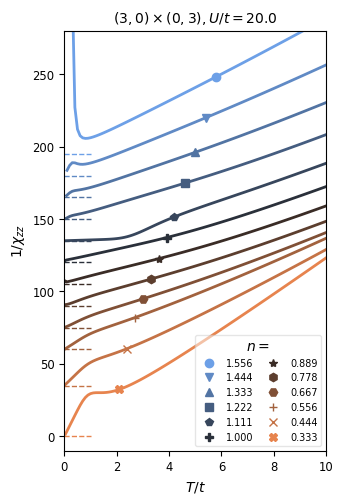

In [248]:
fig = PyPlot.figure(figsize=(3.4, 5))
fig.subplots_adjust(left=0.18, right=0.95, top=0.94, bottom=0.1)
ax = fig.gca()

ymax = 0.0
yoffsets = [15 * (length(n_list) - idx) for idx in 1:length(n_list)]
yoffsets[1:end-1] .+= 20
yoffsets[1:end-2] .+= 10

for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / (n_sites * T)
    #     Sz_avg = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz])) / sum(ssdf[:, :partition]))
        Sz_avg = 0
        if !isnan(corr)
            push!(xs, T)
            push!(ys, corr - Sz_avg^2 / (n_sites * T))
        end
    end
    ys = 1 ./ ys
    yoffset = yoffsets[idx]

    color=cmap((idx-1) / (length(n_list)-1))
    ax.plot(
        xs,
        ys .+ yoffset,
        linestyle="-",
        linewidth=2,
        color=color,
        alpha=1.0,
    )
    let
        xmark = xs[60 - 3*idx]
        ymark = ys[60 - 3*idx] + yoffset
        ax.plot(xmark, ymark, linestyle="None", marker=markers[idx], label=(@sprintf "%.3f" (n/n_sites)),
            color=color,
            alpha=1.0, markersize=6
        )
    end
    ax.plot([0, 1], [yoffset, yoffset], linestyle="--", linewidth=1, color=color, zorder=-3)
    ymax = max(ymax, maximum(ys))
end
ax.set_xlim(0, maximum(temperatures))
ax.set_ylim(-10, 280)

ax.legend(title=raw"$n=$", ncol=2, loc=4, framealpha=0.5, columnspacing=1)
ax.set_xlabel(raw"$T/t$")
ax.set_ylabel(raw"$1/\chi_{zz}$")

ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), U/t=$(U/t)\$")

fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).png", dpi=300)
fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300)


In [253]:
@. model(x, p) = (x - p[2]) / p[1]
temperatures = unique(sort(df[:, :temperature]))
fit_temperatures = [T for T in temperatures if 0.7 <= T <= 5.5]

49-element Vector{Float64}:
 0.7
 0.8
 0.9
 1.0
 1.1
 1.2
 1.3
 1.4
 1.5
 1.6
 1.7
 1.8
 1.9
 ⋮
 4.4
 4.5
 4.6
 4.7
 4.8
 4.9
 5.0
 5.1
 5.2
 5.3
 5.4
 5.5

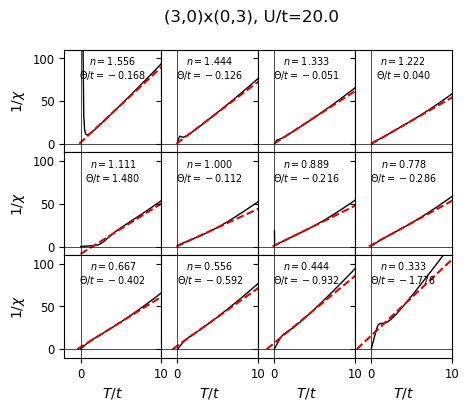

In [268]:
fig = PyPlot.figure(figsize=(5, 4))
axs = fig.subplots(3, 4, sharex=true, sharey=true)
axs = [axs[i,j] for i in 1:3 for j in 1:4]

fig.subplots_adjust(hspace=0, wspace=0)

axs[9].set_xlabel(raw"$T/t$")
axs[10].set_xlabel(raw"$T/t$")
axs[11].set_xlabel(raw"$T/t$")
axs[12].set_xlabel(raw"$T/t$")

axs[1].set_ylabel(raw"$1/\chi$")
axs[5].set_ylabel(raw"$1/\chi$")
axs[9].set_ylabel(raw"$1/\chi$")

fit_params = []
for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / T
        if !isnan(corr)
            push!(xs, T)
            push!(ys, n_sites / corr)
        end
    end

    xs_fit, ys_fit = let i = (0.8 .<= xs .<= 5.5)
        xs[i], ys[i]
    end
    f = curve_fit(model, xs_fit, ys_fit, [1.0, 0.0])
    ax = axs[idx]
    # ax = fig.add_subplot(3, 4, idx, sharex=ax0, sharey=ax0)
    ax.plot(xs, ys, linewidth=1, color="black")
    xfit = [min(f.param[2], 0.0), maximum(xs)] 
    # ax.plot([f.param[2], maximum(xs)], model([f.param[2], maximum(xs)], f.param), linestyle="--", color="xkcd:red")
    ax.plot(xfit, model(xfit, f.param), linestyle="--", color="xkcd:red")

    ax.set_ylim(-10, 110)
    ax.set_xlim(-2, 10)
    ax.text(0.5, 0.95, (@sprintf "\$n=%.3f\$\n\$\\Theta/t=%.3f\$" (n/n_sites) (f.param[2])), ha="center", va="top", transform=ax.transAxes, fontsize="x-small")
#     ax.text(0.5, 0.95, (@sprintf "n=%.3f" (n/n_sites)), ha="center", va="top", transform=ax.transAxes, fontsize="small")
#     ax.set_title("n=$n")
    ax.axhline(0, linewidth=0.5, color="black")
    ax.axvline(0, linewidth=0.5, color="black")
    #ax.set_xscale("log")
    push!(fit_params, [n, f.param[2]] )
end
fit_params = hcat(fit_params...)
fig.suptitle("$(shape_str), U/t=$(U/t)")
fig.savefig("triangular-hubbard-curie-weiss-fits_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300, bbox_inches="tight")
fig.savefig("triangular-hubbard-curie-weiss-fits_$(shape_str)_t=$(t)_U=$(U).png", dpi=300, bbox_inches="tight")


In [ ]:
fig = PyPlot.figure(figsize=(3.5, 3))
ax = fig.gca()
ax2 = ax.twinx()
xs = fit_params[1, :] ./ n_sites
ys = -fit_params[2, :]
ax.plot(xs, ys, "o-")
ax.axhline(0, linewidth=0.5, color="black", zorder=-10)

ymin, ymax = minimum(ys)-0.1, maximum(ys) + 0.1
ax.set_ylim(ymin, ymax)
ax2.set_ylim(ymin * 8.7, ymax*8.7)
ax.set_title("$shape_str, \$t=1, U=20\$")
ax.set_xlabel(raw"$n$")
ax.set_ylabel(raw"$-\theta/t$")
ax2.set_ylabel(raw"$-\theta\,\mathrm{(K)}$")
fig.savefig("weiss-$(shape_str)_fit_to_jieshan.png", dpi=300, bbox_inches="tight")
fig.savefig("weiss-$(shape_str)_fit_to_jieshan.pdf", dpi=300, bbox_inches="tight")


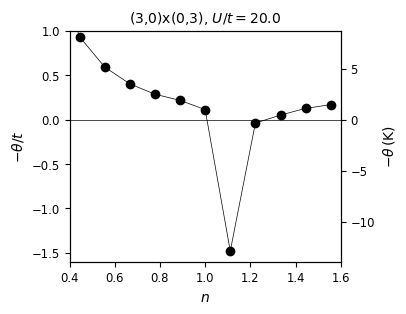

In [261]:
fig = PyPlot.figure(figsize=(3.5, 3))
ax = fig.gca()
ax2 = ax.twinx()
xs = fit_params[1, :] ./ n_sites
ys = -fit_params[2, :]
ax.plot(xs, ys, "o-" , color="black", linewidth=0.5)
ax.axhline(0, linewidth=0.5, color="black", zorder=-10)

ymin, ymax = minimum(ys)-0.1, maximum(ys) + 0.1
ax.set_xlim(0.4, 1.6)
ymin = -1.6
ymax = 1.0
ax.set_ylim(ymin, ymax)
ax2.set_ylim(ymin * 8.7, ymax*8.7)
ax.set_title("$shape_str, \$U/t=$(U/t)\$")
ax.set_xlabel(raw"$n$")
ax.set_ylabel(raw"$-\theta/t$")
ax2.set_ylabel(raw"$-\theta\,\mathrm{(K)}$")
fig.savefig("weisstemp-$(shape_str)_fit_to_jieshan.png", dpi=300, bbox_inches="tight")
fig.savefig("weisstemp-$(shape_str)_fit_to_jieshan.pdf", dpi=300, bbox_inches="tight")


In [269]:
# full range

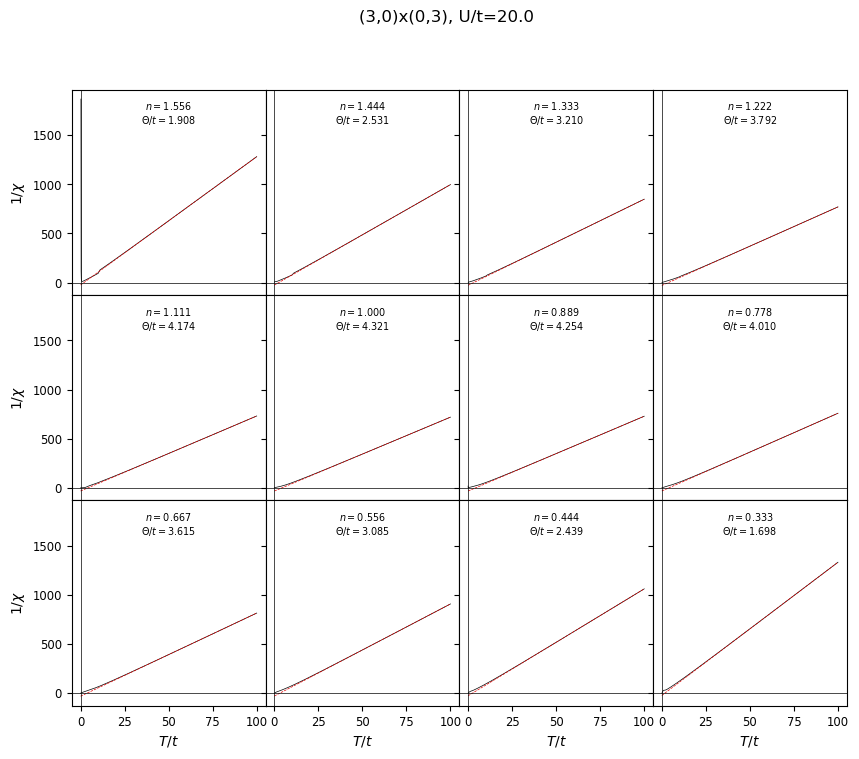

In [279]:
fig = PyPlot.figure(figsize=(10, 8))
axs = fig.subplots(3, 4, sharex=true, sharey=true)
axs = [axs[i,j] for i in 1:3 for j in 1:4]

fig.subplots_adjust(hspace=0, wspace=0)

axs[9].set_xlabel(raw"$T/t$")
axs[10].set_xlabel(raw"$T/t$")
axs[11].set_xlabel(raw"$T/t$")
axs[12].set_xlabel(raw"$T/t$")

axs[1].set_ylabel(raw"$1/\chi$")
axs[5].set_ylabel(raw"$1/\chi$")
axs[9].set_ylabel(raw"$1/\chi$")

fit_params = []
for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / T
        if !isnan(corr)
            push!(xs, T)
            push!(ys, n_sites / corr)
        end
    end

    xs_fit, ys_fit = let i = (50 .<= xs)
        xs[i], ys[i]
    end
    f = curve_fit(model, xs_fit, ys_fit, [1.0, 0.0])
    ax = axs[idx]
    # ax = fig.add_subplot(3, 4, idx, sharex=ax0, sharey=ax0)
    ax.plot(xs, ys, linewidth=0.5, color="black")
    xfit = [min(f.param[2], 0.0), maximum(xs)] 
    # ax.plot([f.param[2], maximum(xs)], model([f.param[2], maximum(xs)], f.param), linestyle="--", color="xkcd:red")
    ax.plot(xfit, model(xfit, f.param), linewidth=0.5, linestyle="--", color="xkcd:red")

#     ax.set_ylim(-10, 120)
#     ax.set_xlim(-2, 10)
    ax.text(0.5, 0.95, (@sprintf "\$n=%.3f\$\n\$\\Theta/t=%.3f\$" (n/n_sites) (f.param[2])), ha="center", va="top", transform=ax.transAxes, fontsize="x-small")
#     ax.text(0.5, 0.95, (@sprintf "n=%.3f" (n/n_sites)), ha="center", va="top", transform=ax.transAxes, fontsize="small")
#     ax.set_title("n=$n")
    ax.axhline(0, linewidth=0.5, color="black")
    ax.axvline(0, linewidth=0.5, color="black")
    #ax.set_xscale("log")
    push!(fit_params, [n, f.param[2]] )
end
fit_params = hcat(fit_params...)
fig.suptitle("$(shape_str), U/t=$(U/t)")
# fig.savefig("triangular-hubbard-curie-weiss-fits_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300, bbox_inches="tight")
# fig.savefig("triangular-hubbard-curie-weiss-fits_$(shape_str)_t=$(t)_U=$(U).png", dpi=300, bbox_inches="tight")
fig.savefig("foo.pdf", bbox_inches="tight")

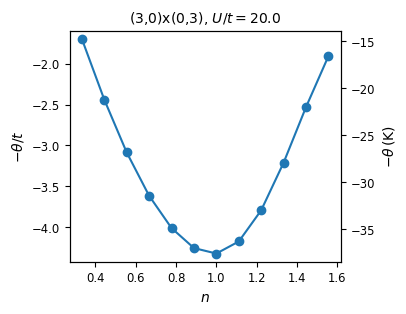

PyObject Text(380.55555555555554, 0.5, '$-\\theta\\,\\mathrm{(K)}$')

In [277]:
fig = PyPlot.figure(figsize=(3.5, 3))
ax = fig.gca()
ax2 = ax.twinx()
xs = fit_params[1, :] ./ n_sites
ys = -fit_params[2, :]
ax.plot(xs, ys, "o-")
ax.axhline(0, linewidth=0.5, color="black", zorder=-10)

ymin, ymax = minimum(ys)-0.1, maximum(ys) + 0.1
ax.set_ylim(ymin, ymax)
ax2.set_ylim(ymin * 8.7, ymax*8.7)
ax.set_title("$shape_str, \$U/t=$(U/t)\$")
ax.set_xlabel(raw"$n$")
ax.set_ylabel(raw"$-\theta/t$")
ax2.set_ylabel(raw"$-\theta\,\mathrm{(K)}$")
# fig.savefig("weiss-$(shape_str)_fit_to_jieshan.png", dpi=300, bbox_inches="tight")
# fig.savefig("weiss-$(shape_str)_fit_to_jieshan.pdf", dpi=300, bbox_inches="tight")


## Plot Charge

In [277]:
# Plot Charge susceptibility
sdf = df
chemical_potentials = -20:0.1:40
Qg = zeros(Float64, (length(temperatures), length(chemical_potentials)))
χg = zeros(Float64, (length(temperatures), length(chemical_potentials)))
Tg = zeros(Float64, (length(temperatures), length(chemical_potentials)))
μg = zeros(Float64, (length(temperatures), length(chemical_potentials)))
@showprogress for (imu, mu) in enumerate(chemical_potentials)
    for (iT, T) in enumerate(temperatures)
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        z_ = Float128.(ssdf[:, :partition])
        q_ = Float128.(ssdf[:, :charge])
        T_ = Float128(T)
        mu_ = Float128(mu)
        emu_ = exp.(mu_ .* q_ / T_)
        qavg_ = sum(q_ .* z_ .* emu_) ./ sum(z_ .* emu_)
        q2avg_ = sum( q_ .* q_ .* z_ .* emu_) ./ sum(z_ .* emu_)
        Qg[iT, imu] = qavg_
        χg[iT, imu] = (q2avg_ - qavg_.^2) ./ (n_sites * T_)
        Tg[iT, imu] = T
        μg[iT, imu] = mu
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:55


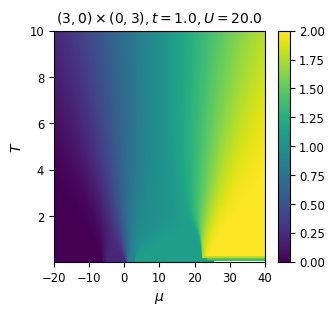

In [333]:
fig = PyPlot.figure(figsize=(3.4, 3))
ax = fig.gca()
# img = ax.imshow(result, extent=[minimum(chemical_potentials), maximum(chemical_potentials), minimum(temperatures), maximum(temperatures)],
# aspect="auto", interpolation="None")
img = ax.pcolor(μg, Tg, Qg ./ n_sites, vmin=0, vmax=2)
ax.set_xlabel(raw"$\mu$")
ax.set_ylabel(raw"$T$")
ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), t=$t, U=$U\$")

fig.colorbar(mappable=img)
# fig.savefig("triangular-hubbard-charge-$(shape_str)_t=$(t)_U=$(U).png", dpi=300)
fig.savefig("triangular-hubbard-charge-$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300, bbox_inches="tight")


In [281]:
χg[isnan.(χg)] .= 0
χg[abs.(χg) .< 1E-8] .= 0
;

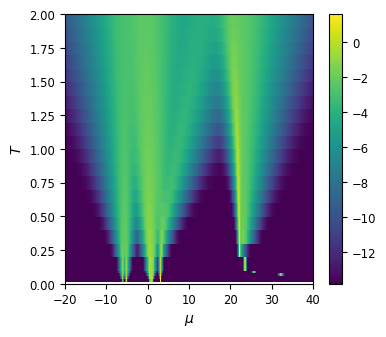

(0.0, 2.0)

In [282]:
fig = PyPlot.figure(figsize=(4, 3.5))
ax = fig.gca()
# img = ax.imshow(result, extent=[minimum(chemical_potentials), maximum(chemical_potentials), minimum(temperatures), maximum(temperatures)],
# aspect="auto", interpolation="None")
img = ax.pcolor(μg, Tg, log.(χg .+ 1E-6))
ax.set_xlabel(raw"$\mu$")
ax.set_ylabel(raw"$T$")
fig.colorbar(mappable=img)
ax.set_ylim(0, 2)

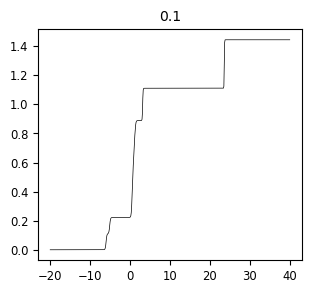

PyObject Text(0.5, 1.0, '0.1')

In [341]:
# for i in 1:size(μg, 1)
fig = PyPlot.figure(figsize=(3.4, 3))
let i = 5
    PyPlot.plot(μg[i, :], Qg[i, :] ./ n_sites, linewidth=0.5, color="black")
    PyPlot.title("$(Tg[i, 1])")
end